In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import signal

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import hvplot.xarray
 
from mlprecip_utils import *

import mlprecip_utils

import warnings
warnings.filterwarnings("ignore")

/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib

In [2]:
cmap='DryWet'
clevs=np.arange(-0.8,0.9,0.1)
labels=['Positive','Neutral','Negative']
v='precip'

# SEUS
lat_reg=[24.0,36.0]
lon_reg=[269.0,283.0]

winter=[12,1,2]
summer=[6,7,8]
sdate='1979-01-01'
edate='2019-12-31'
bins=[-100,-0.5,0.5,100]

In [3]:
# Read in Precip Data
#fnames='/scratch/zmanthos/GPCP/gpcp_v01r03_daily.*.nc'
#ds=getPrecipData(fnames,'1996-12-15','2020-01-15')

# Read in mask file and interpolate
#lmask_file='/shared/subx/hindcast/land_cover.nc'
#ds_mask=xr.open_dataset(lmask_file)
#ds_mask=ds_mask.interp(lat=ds['lat'],lon=ds['lon'])
# Maskout Land
#ds=ds.where(ds_mask['land']==1)

fnames='/shared/ccsm4/kpegion/obs2/CPC-UNI/precip.V1.0.*.nc'
ds=xr.open_mfdataset(fnames,combine='by_coords').sel(time=slice(sdate,edate))

# Subset to SEUS
ds_seus=ds.sel(lat=slice(lat_reg[0],lat_reg[1]),lon=slice(lon_reg[0],lon_reg[1]))

# Calculate Anomalies
ds_anoms=ds_seus.groupby('time.dayofyear')-ds_seus.groupby('time.dayofyear').mean()

ds_anoms


<xarray.Dataset>
Dimensions:    (lat: 48, lon: 56, time: 14975)
Coordinates:
  * lat        (lat) float32 24.12 24.38 24.62 24.88 ... 35.12 35.38 35.62 35.88
  * lon        (lon) float32 269.1 269.4 269.6 269.9 ... 282.1 282.4 282.6 282.9
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Data variables:
    precip     (time, lat, lon) float32 dask.array<chunksize=(1, 48, 56), meta=np.ndarray>

In [4]:
pna_file='/project/predictability/kpegion/wxregimes/era-interim/erai.z500_u250_pna_5dyrm_JJA.1980-2015.anoms.nc'
ds=xr.open_dataset(pna_file) 
ds=(ds-ds.mean(dim='time'))/ds.std(dim='time')

# Loop over seasons
for seas,slabel,seas_abbrv in zip([summer],['Summer'],['JJA']):

    # Select season from predictor index and target index
    ds_i=ds.sel(time=ds['time.month'].isin(seas))   
    ds_p=ds_anoms.sel(time=ds_anoms['time.month'].isin(seas))

    #----- FIT MODELS AND TEST  -----------#

    # Define Features
    ds_features=ds  
    
    # Define Index Target as Mean precip in region
    ds_target=ds_p.mean(dim=['lat','lon'])
        
    # Make sure we have the same times for target and features
    ds_target,ds_features=xr.align(ds_target,ds_features,join='inner')

    # Test the prediction of precipitation in category defined by threshold
    print('============= Categorical upper ================')
    nmodels=10
    thresh=np.percentile(ds_target['precip'],50)
    print("Upper: ",thresh)
    ds_model=testModelsCatField(ds_features,xr.where(ds_target>thresh,0,1),nmodels)
    ds_model=ds_model.stack(allpreds=("model", "time"))

============= Categorical upper ================
Upper:  0.579904983043671
Check Features and Target Dimensions
Features (X):  (3080, 22, 53, 2)
Target (Y):  (3080,)
Samples:  3080
Features:  (22, 53, 2)
Training Size:  2464
Testing Size:  616
CHECK NN:  In Category  266  Not in category:  2198
NN Training set accuracy score: 0.7004870122129266
NN Test set accuracy score: 0.7045454522231956
CHECK NN:  In Category  0  Not in category:  2464
NN Training set accuracy score: 0.6582792223273933
NN Test set accuracy score: 0.66720779685231
CHECK NN:  In Category  315  Not in category:  2149
NN Training set accuracy score: 0.7008928579169434
NN Test set accuracy score: 0.6964285683322262
CHECK NN:  In Category  292  Not in category:  2172
NN Training set accuracy score: 0.6964285722026577
NN Test set accuracy score: 0.6834415630860762
CHECK NN:  In Category  358  Not in category:  2106
NN Training set accuracy score: 0.6996753262234973
NN Test set accuracy score: 0.6899350688054964
CHECK NN: 

Upper:  0 True
392


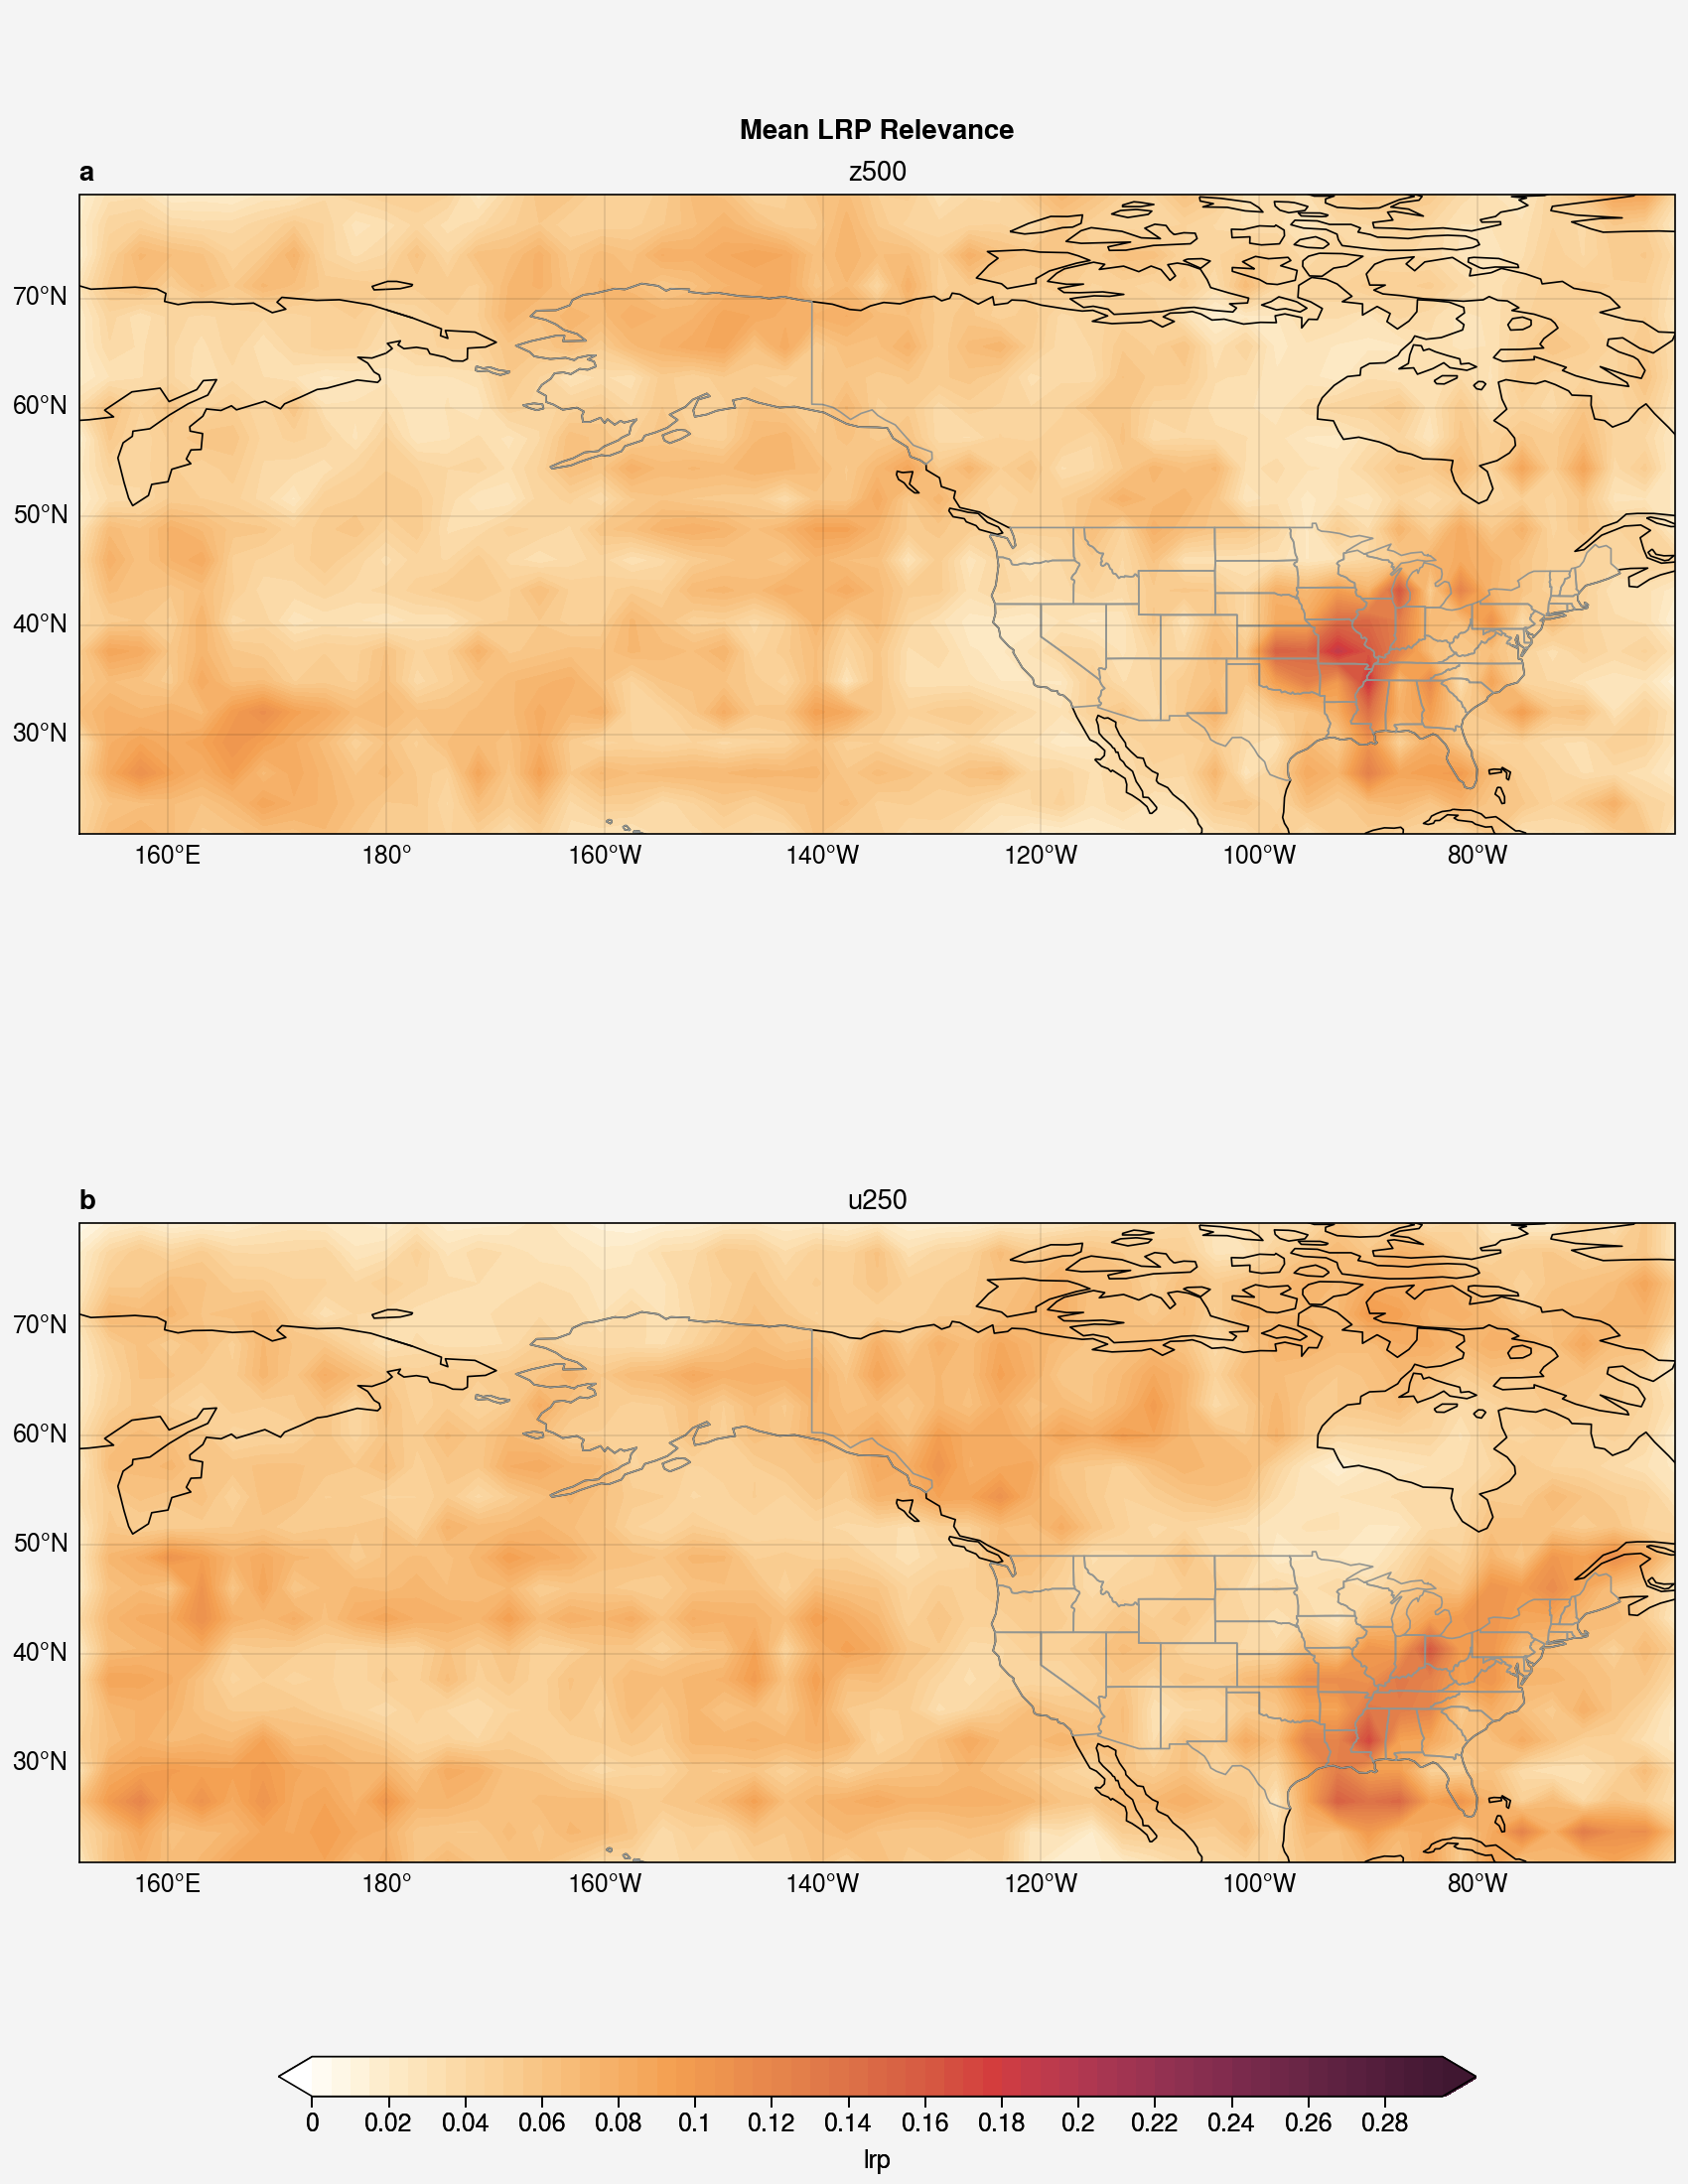

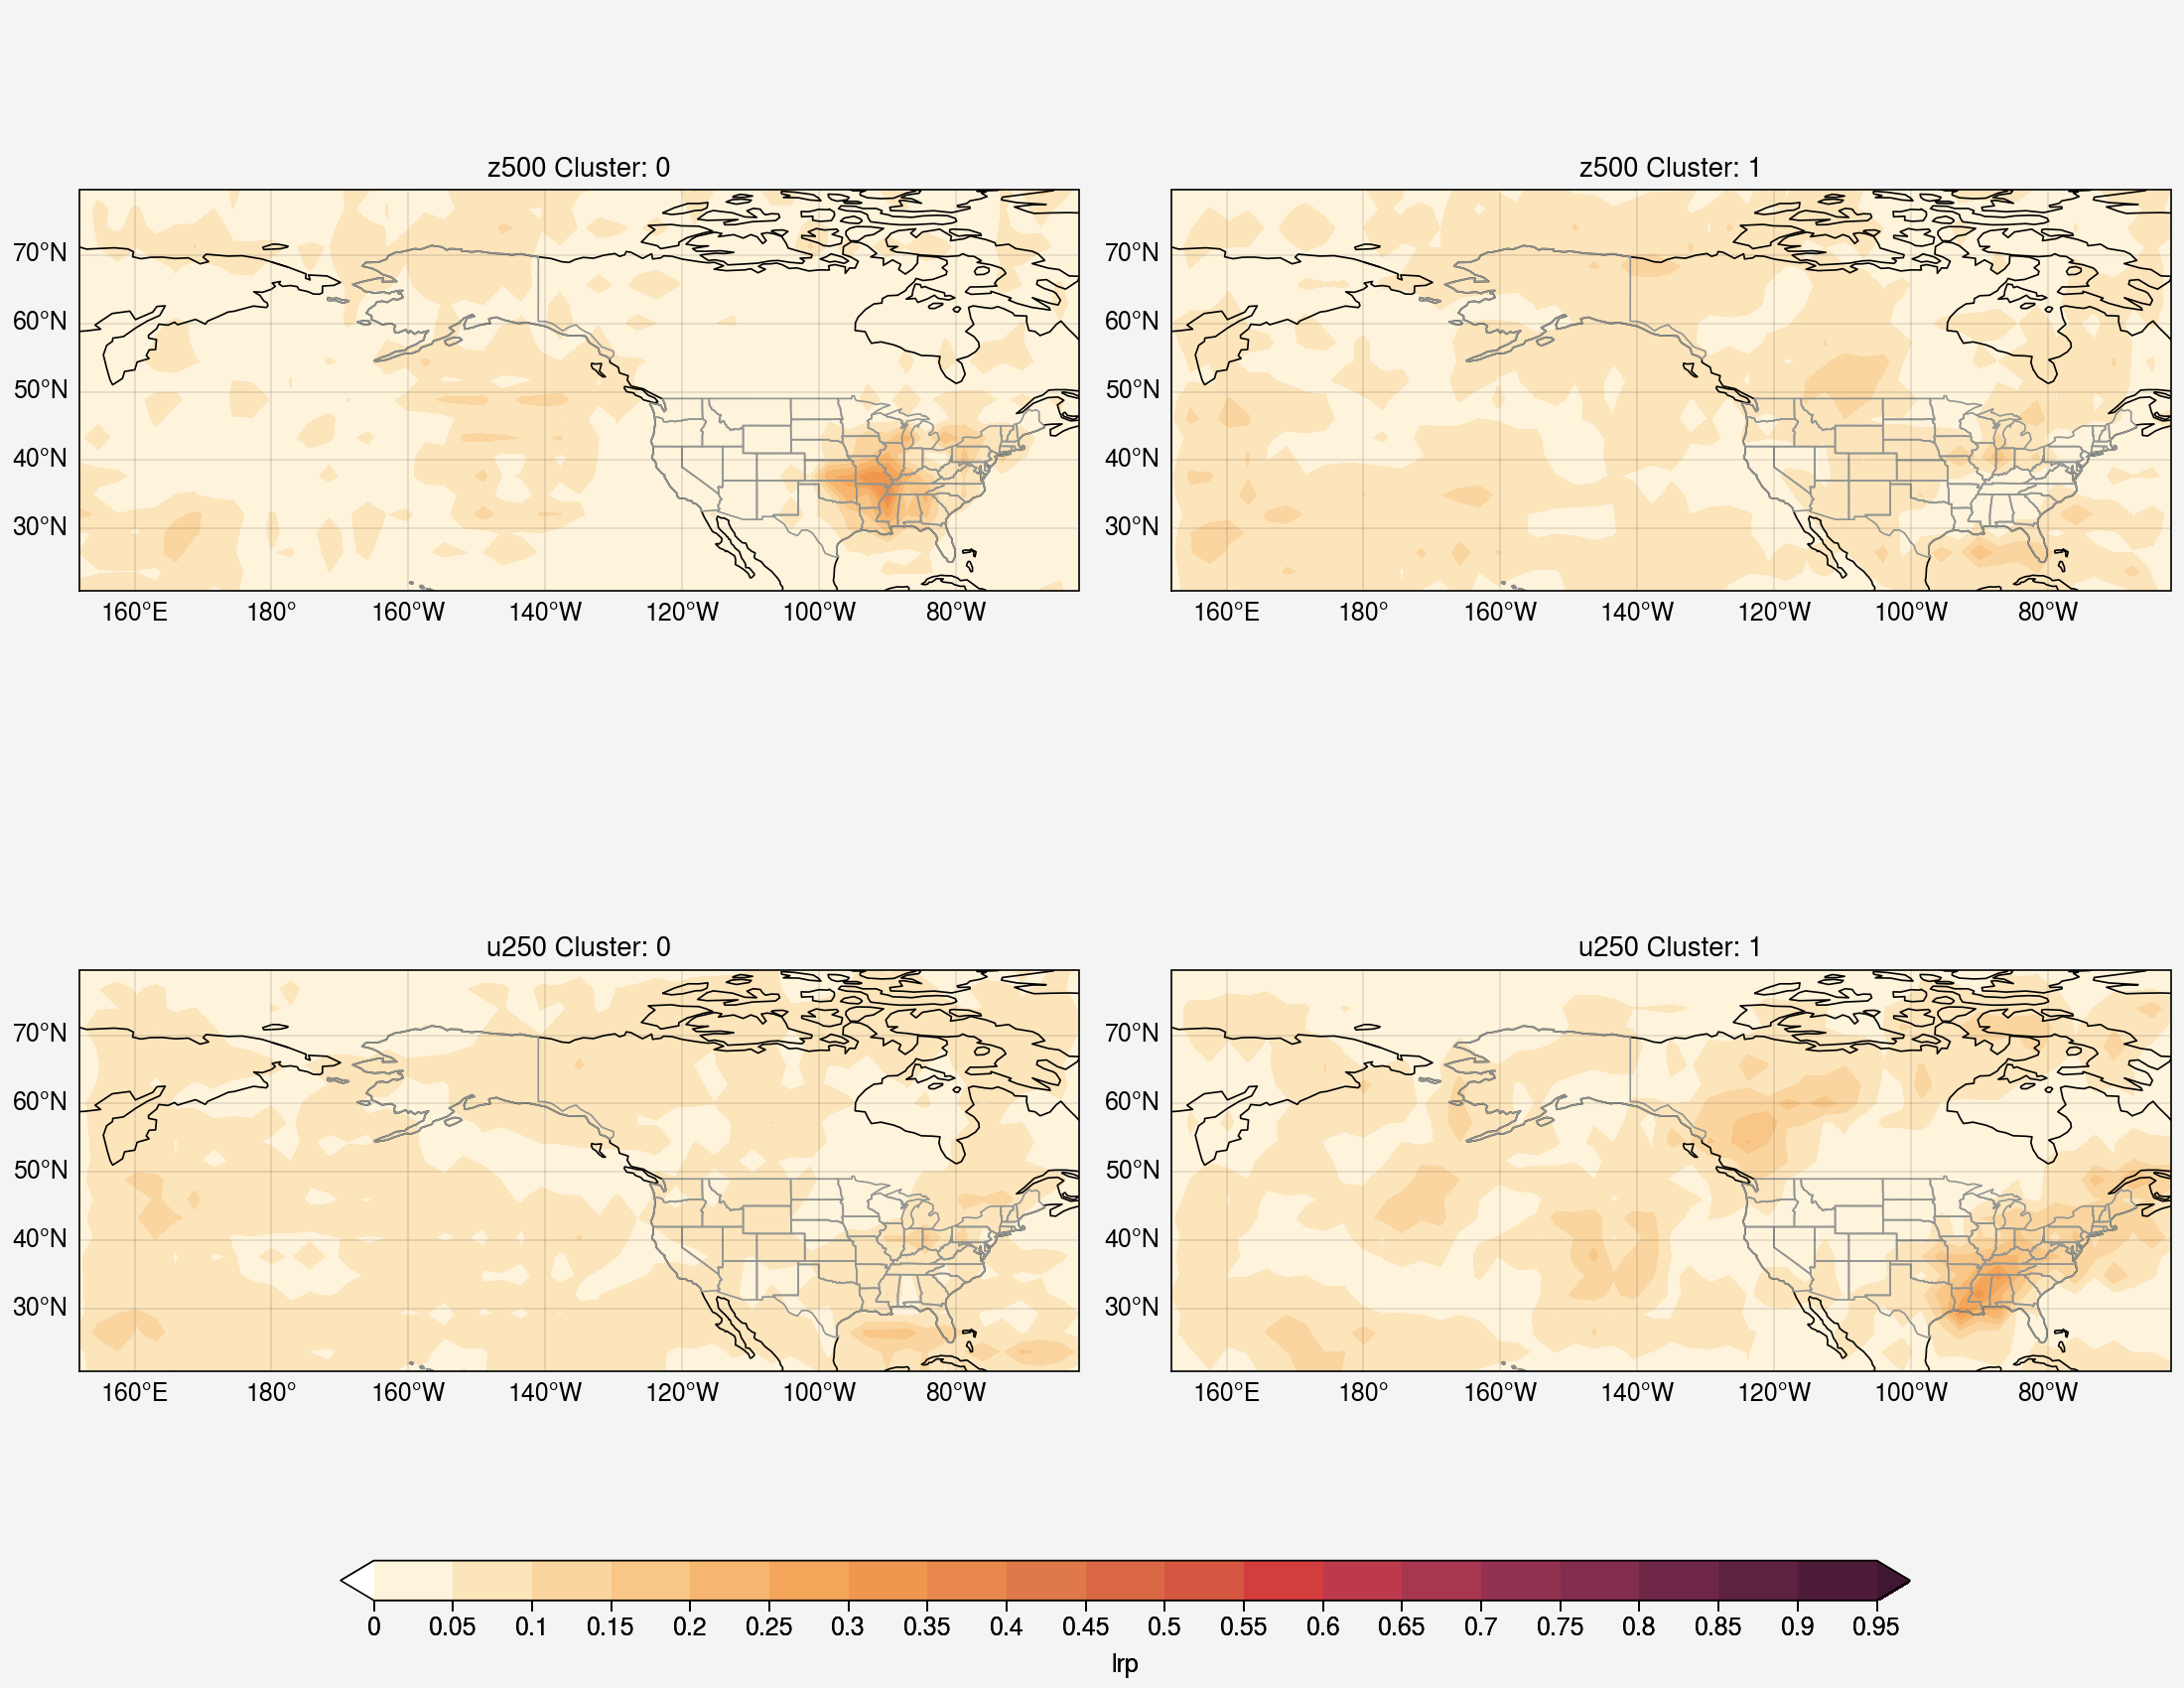

In [6]:
for cat,l in zip([0],['True']):
    print("Upper: ",cat,l)
    tmp=ds_model.where(np.logical_and(ds_model['pred']==cat,ds_model['verif']==cat))
    tmp2=xr.where(tmp['probs'].sel(cat=l)>=0.6,tmp,np.nan)
    print(np.count_nonzero(~np.isnan(tmp2['pred'])))
    plotLRP(tmp2,'allpreds')
    LRPClusters(tmp2.dropna(dim='allpreds'),'allpreds')
    

In [7]:
ds_model

<xarray.Dataset>
Dimensions:   (allpreds: 24640, cat: 2, lat: 22, lon: 53, var: 2)
Coordinates:
  * lat       (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon       (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
  * var       (var) <U4 'z500' 'u250'
  * cat       (cat) <U5 'True' 'False'
  * allpreds  (allpreds) MultiIndex
  - model     (allpreds) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 9 9 9 9 9 9 9 9 9 9 9
  - time      (allpreds) datetime64[ns] 1980-06-03 1980-06-04 ... 2007-08-29
Data variables:
    lrp       (lat, lon, var, allpreds) float32 0.0 0.0 -0.0 ... 0.0 0.0 0.0
    pred      (allpreds) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    verif     (allpreds) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 0 0 0 0 1
    probs     (cat, allpreds) float32 0.1817 0.1219 0.08976 ... 0.6067 0.6075
    acc       (allpreds) float64 0.7005 0.7005 0.7005 ... 0.6972 0.6972 0.6972
    val_acc   (allpreds) float64 0.7045 0.7045 0.7045 ... 0.7192 0.7192 0.7192

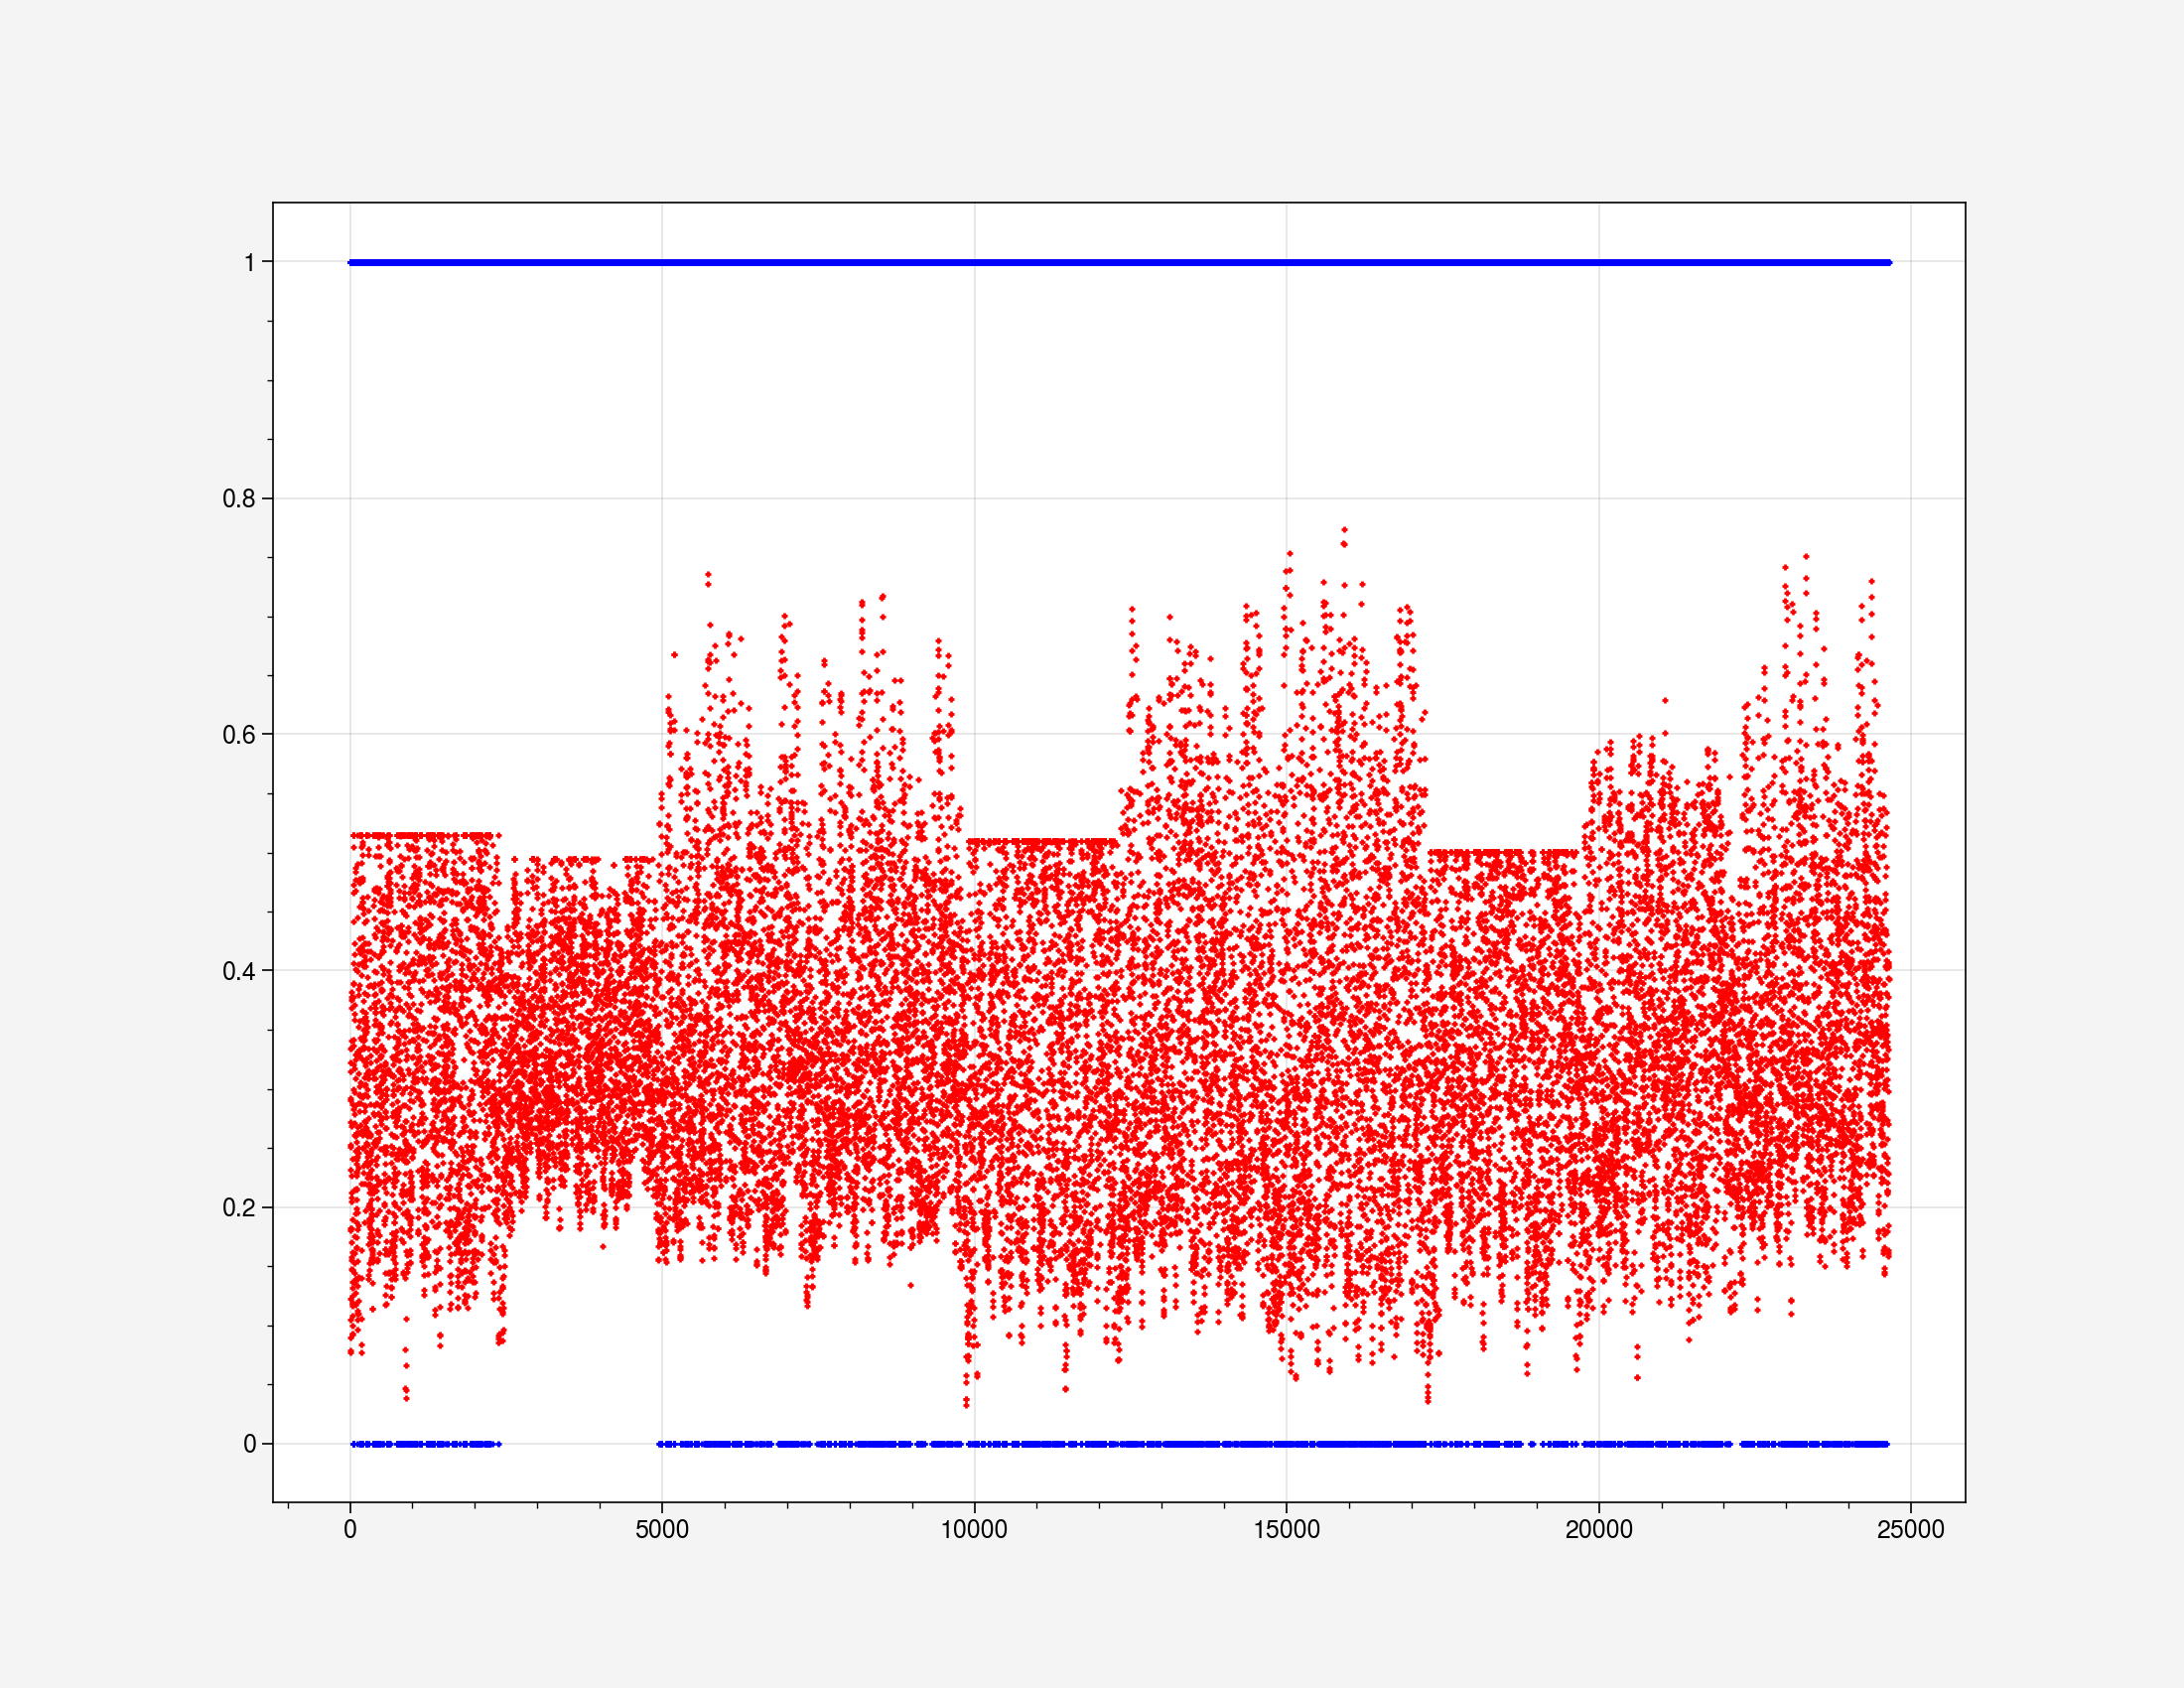

In [8]:
plt.figure(figsize=(11,8.5))
plt.plot(np.arange(len(ds_model['allpreds'])),ds_model['pred'],'b+',markersize=2)
plt.plot(np.arange(len(ds_model['allpreds'])),ds_model['probs'][0,:],'r+',markersize=2)

In [20]:
da=ds_anoms['precip'].mean(dim=['lat','lon'])

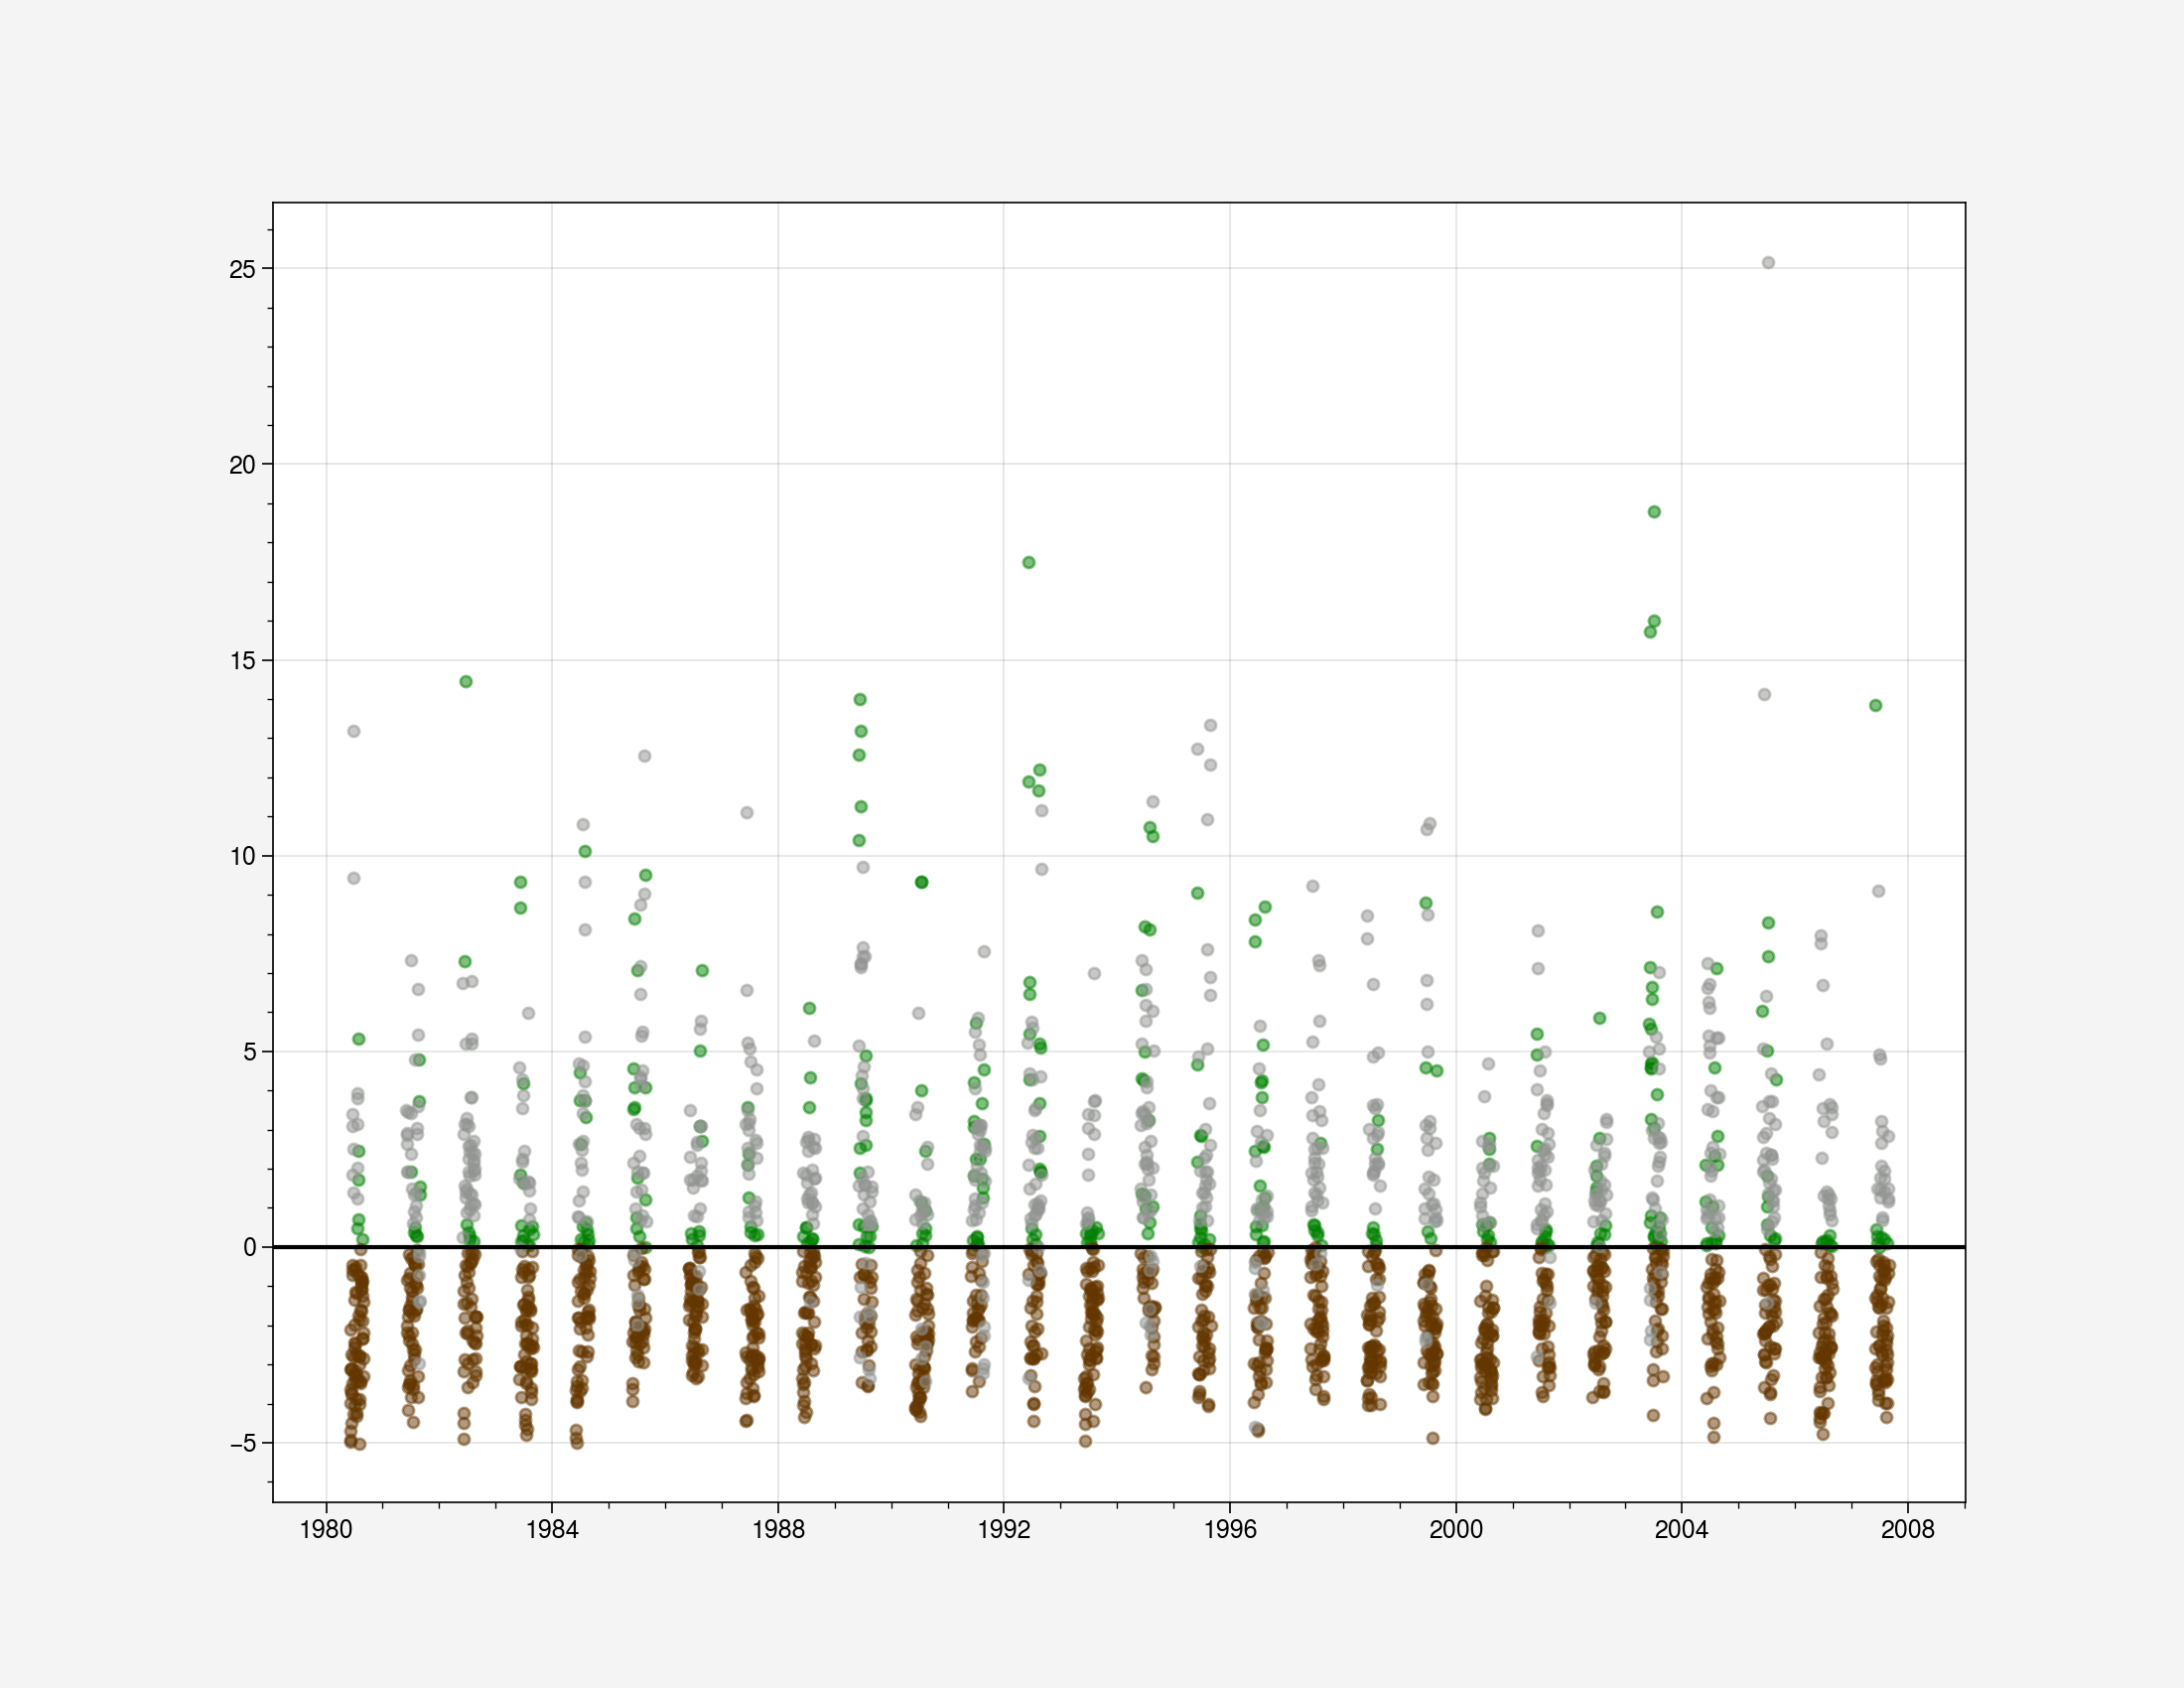

In [60]:
plt.figure(figsize=(11,8.5))

tmp=da.where(np.logical_and(ds_model['pred'].sel(model=0)==ds_model['verif'].sel(model=0),da>0.0))
plt.plot(tmp['time'],tmp,'g.',markersize=8,linestyle='None',alpha=0.5)

tmp=da.where(np.logical_and(ds_model['pred'].sel(model=0)==ds_model['verif'].sel(model=0),da<0.0))
plt.plot(tmp['time'],tmp,color='brown',marker='.',markersize=8,linestyle='None',alpha=0.5)

tmp=da.where(ds_model['pred'].sel(model=0)!=ds_model['verif'].sel(model=0))
plt.plot(tmp['time'],tmp,color='gray',marker='.',markersize=8,linestyle='None',alpha=0.5)

plt.axhline(0,color='k')